## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [3]:
data.dropna(axis=0, inplace=True) # уберем пропуски

In [4]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['FEMALE', 'MALE']], handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
data['Sex'] = encoder.fit_transform(data[['Sex']])

encoder = OrdinalEncoder(categories=[['No', 'Yes']], dtype=int)
data['Clutch Completion'] = encoder.fit_transform(data[['Clutch Completion']])

data = pd.concat([data, pd.get_dummies(data['Island'], prefix='Island', dtype='int')], axis=1) # one-hot encoding

In [5]:
data.drop(['Island'], axis=1, inplace=True) # закодировали выше
data.rename(columns={'Sex' : 'Male'}, inplace=True) # переименуем по смыслу

Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [6]:
encoder = OrdinalEncoder(categories=[['Chinstrap', 'Gentoo', 'Adelie']])
data['Species'] = encoder.fit_transform(data[['Species']]).astype(int)

#### Разберемся с точкой в признаке `Sex`

In [7]:
gentos = data[data['Species'] == 1] # будем рассматривать отдельно вид пингвинов, среди которых в признаке есть точка

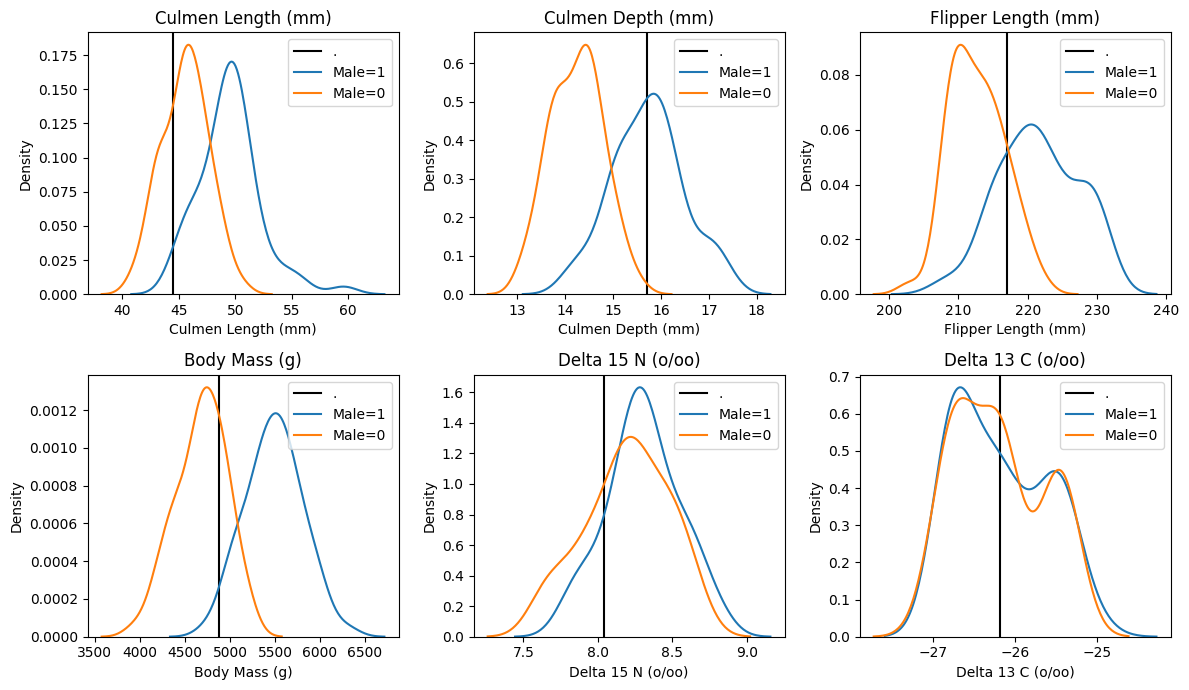

In [8]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
signes = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 
          'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'] # признаки для графиков

for i in range(6):
    ax = axes.flatten()[i]
    ax.axvline(x=gentos[signes[i]][gentos['Male'] == -1].iloc[0], color='black', label='.') # значение пингвина с точкой
    for male in [1, 0]: # строим отдельно для двух полов
        df = gentos[gentos['Male'] == male]
        sns.kdeplot(data=df, x=signes[i], ax=ax, label=f"Male={male}", linewidth=1.5)
    ax.set_title(signes[i]) 
    ax.legend() 

plt.tight_layout() 
plt.show()

На представленных выше графиках сделанных для пингвинов вида `Gentoo` нельзя с большой уверенностью сказать, что интересующий нас объект относится к той или иной группе по рассматриваемому признаку. На графиках не представленны другие признаки, так как они или имеют сильную несбалансированность заначений, или совсем не отличаются в зависимости от пола, или не имеют никакой связи с полом пингвина.

In [9]:
data.drop(data[data['Male'] == -1].index, inplace=True) # удаляем небинарного пингвина

#### Ответ:
Признак `Sex` был закодирован 1 при `male` и 0 при `female` (пропуски и . удалены), а после переименован в `Male`. Бинарное кодирование в данном случае оптимально, это позволит разнести объекты по разные стороны оси (имею ввиду ось гиперплоскости). Объекты по этому признаку строго делятся на 2 группы. Признак `Clutch Completion` имел значения `Yes` и `No`, является "булевским", поэтому был закодирован 1 и 0 соответственно. К признаку `Island` был применен One-hot-encoding, поскольку острова 3, их невозможно сравнить между собой и никакие два из них не должны быть ближе к друг другу, чем оставшийся (про гиперплоскость). Получилось три столбца, любой из них можно определить двумя другими, но было принято решение оставить все 3, так как количество строк небольшое и дальнейший анализ будет удобнее

In [10]:
X = data.drop('Species', axis=1) # отделим признаки и таргет
y = data['Species']

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [11]:
np.random.seed(52)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Stratify необходим для равномерных пропорций между классами в выборке, это важно, так отношение классов в train и test не должно сильно отличаться

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[['Flipper Length (mm)', 'Body Mass (g)']])
X_test_scaled = scaler.transform(X_test[['Flipper Length (mm)', 'Body Mass (g)']]) 

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knns = []
for k in [1, 3, 5, 10, 15, 25]:
    knns.append(KNeighborsClassifier(n_neighbors=k, metric='euclidean').fit(X_train_scaled, y_train))


print('NN  Train  Test')
for lab, knn in zip([1, 3, 5, 10, 15, 25], knns):
    print(f'{lab}    {accuracy_score(y_train, knn.predict(X_train_scaled)):.2f}  {accuracy_score(y_test, knn.predict(X_test_scaled)):.2f}')

NN  Train  Test
1    0.96  0.82
3    0.84  0.78
5    0.83  0.78
10    0.80  0.85
15    0.81  0.83
25    0.80  0.81


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [15]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

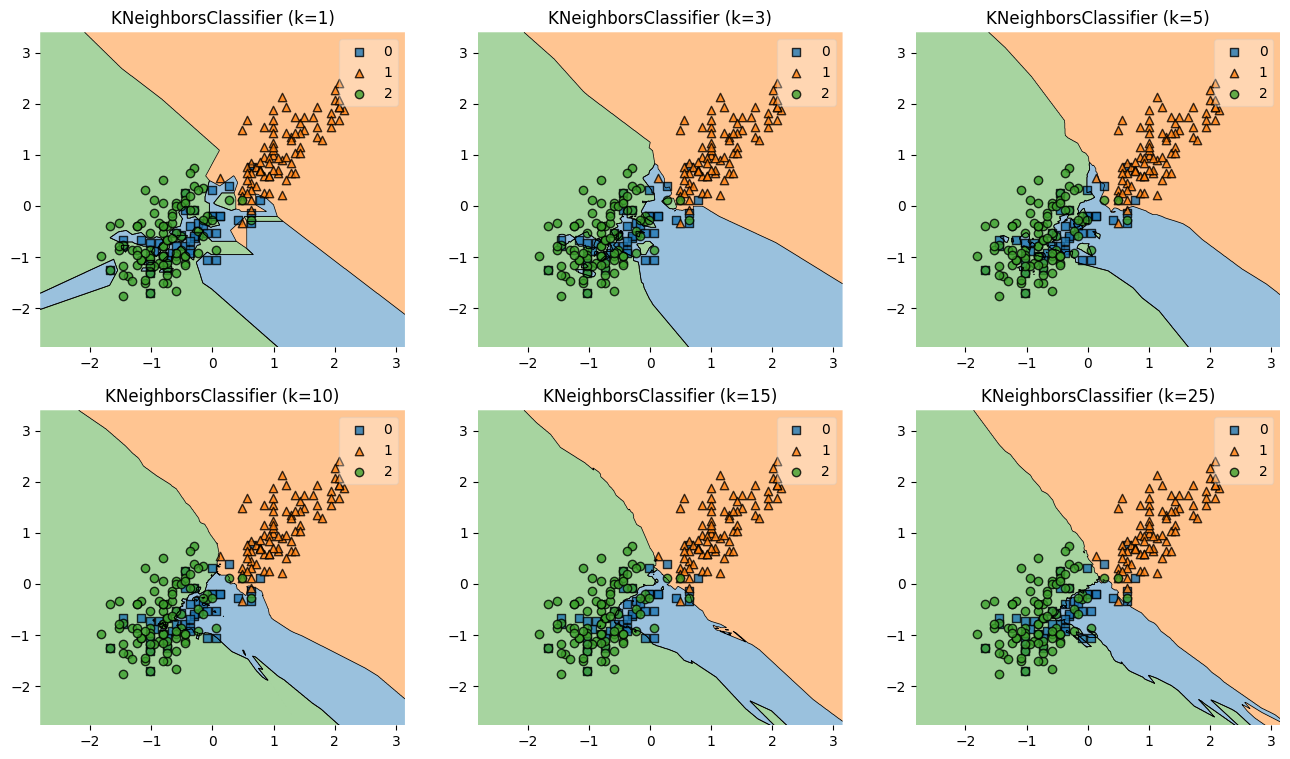

In [16]:
from mlxtend.plotting import plot_decision_regions
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for clsf, ax, label in zip(knns, axes.flatten(), [1, 3, 5, 10, 15, 25]):
    fig = plot_decision_regions(X_train_scaled, y_train.values, clsf, ax=ax, n_jobs=-1)
    ax.set_title(f'KNeighborsClassifier (k={label})')
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Оптимальное число соседей - 10. При к=1 модель плохо обобщает, границы плоскости слишком "ломанные", есть большое количество "островов". При к=3 модель всё ещё может быть сильно чуствительна к шуму и зависеть от конкретных точек. При к=5, к=10 и к=15 модели лучше отражают реальное разграничение классов и имеют схожие, достаточно хорошие доли правильных ответов. При к=25 модель имеет симптомы переобучения, также 25 - достаточно много, учитывая расположение и количество объектов классов (в одном классе всего 67 объектов)

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

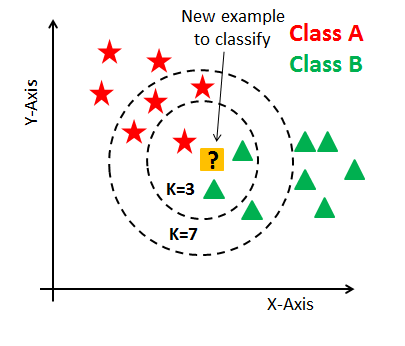

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [64]:
import numpy as np

class GaussBiasBinClsf:
    def __init__(self, n_classes: int, P: np.array = None, lm: np.array = None):
        if P is None:
            self.P = np.array([1.0 / n_classes] * n_classes)
        else:
            self.P = P
        if lm is None: 
            self.lm = np.zeros(n_classes)
        else:
            self.lm = lm
        self.n_classes = n_classes
        
    def fit(self, X_train: np.array, y_train: np.array):
        self.classes = np.unique(y_train)
        self.means = np.zeros((self.n_classes, X_train.shape[1]))
        self.cov_matrixes = [np.zeros((X_train.shape[1], X_train.shape[1])) for _ in range(self.n_classes)]
        
        for i, cls in enumerate(self.classes):
            class_samples = X_train[y_train == cls]
            self.means[i] = np.mean(class_samples, axis=0)
            self.cov_matrixes[i] = np.cov(class_samples, rowvar=False)
        return self
    
    def __clsf__(self, x: np.array) -> np.int64:
        def gaussian_pdf(x, mean, cov_matrix):
            dim = len(x)
            cov_matrix = cov_matrix + np.eye(dim) * 1e-6
            coef = 1 / ((2 * np.pi) ** (dim / 2) * np.linalg.det(cov_matrix) ** 0.5)
            diff = x - mean
            exponent = -0.5 * diff.T @ np.linalg.inv(cov_matrix) @ diff
            return coef * np.exp(exponent)
        
        probs = np.array([gaussian_pdf(x, mean_v, cov_matrix) 
                         for mean_v, cov_matrix in zip(self.means, self.cov_matrixes)])
        
        probs = probs * self.P - self.lm
        
        return self.classes[np.argmax(probs)]
    
    def predict(self, X: np.array):
        return np.array([self.__clsf__(x) for x in X])

In [18]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [19]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [ ]:
scaler = StandardScaler()
"""Протестируем для всех признаков (по мотивам обсуждения в чате)"""

numeric = ['Date Egg', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

X_train_scaled_all = X_train.copy()
X_train_scaled_all[numeric] = scaler.fit_transform(X_train[numeric]) 

X_test_scaled_all = X_test.copy()
X_test_scaled_all[numeric] = scaler.transform(X_test[numeric])

clsf = GaussBiasBinClsf(3, [np.mean(y_train == 0), np.mean(y_train == 1), np.mean(y_train == 2)])
X_train_scaled_all = X_train_scaled_all.to_numpy()
y_train = np.array(y_train)

X_test_scaled_all = X_test_scaled_all.to_numpy()
y_test = np.array(y_test)

clsf.fit(X_train_scaled_all, y_train)

predicts = clsf.predict(X_train_scaled_all)
print(accuracy_score(y_train, predicts))
predicts = clsf.predict(X_test_scaled_all)
print(accuracy_score(y_test, predicts))


0.9690265486725663
0.9897959183673469


In [21]:
scores.iloc[scores['accuracy'].idxmax()]

k           3.0
accuracy    1.0
Name: 1, dtype: float64

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [22]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [23]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Пропущенных значений нет

In [24]:
data.drop('Unnamed: 0', axis=1, inplace=True) # просто индекс

**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

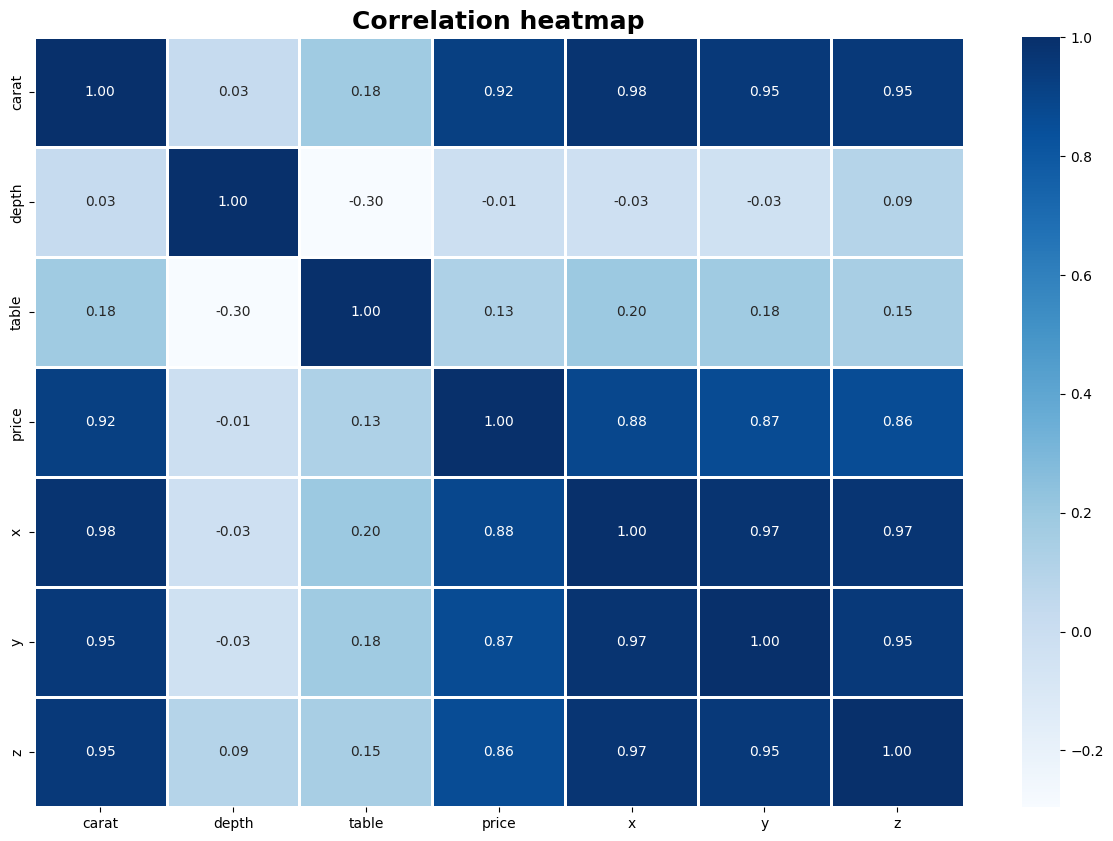

In [25]:
import seaborn as sns
plt.figure(figsize=(15, 10))
plt.title('Correlation heatmap', fontweight='bold', fontsize=18)

ax = sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Blues', linewidths=2)
     
plt.show()

#### Ответ:
Наибольшую корреляцию с таргетом имеют признаки `carat` (очевидно) - 0.92 и признаки `x`, `y`, `z` - 0.88, 0.87, 0.86 соответственно. Также можно заметить очень высокую зависимость в парах из признаков `x`, `y`, `z` - 0.95 - 0.97. Признаки `depth` и `table` крайне слабо коррелируют с целевой переменной.

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False, drop='first') # уберем мультиколлинеарность 

for name in ['color', 'cut', 'clarity']:
    encoded_columns = enc.fit_transform(data[[name]])
    encoded_df = pd.DataFrame(encoded_columns, columns=enc.get_feature_names_out([name]), dtype=int)
    data = pd.concat([data, encoded_df], axis=1)
    data.drop(columns=[name], inplace=True)

In [27]:
data.head(5)

,carat,depth,table,price,x,y,z,color_E,color_F,color_G,...,cut_Ideal,cut_Premium,cut_Very Good,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [28]:
"""Stratify по перцентилям Price"""
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.3, stratify=pd.qcut(data['price'], q=5, labels=False), random_state=52)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [29]:
scaler = StandardScaler()

numeric = ['carat', 'depth', 'table', 'x', 'y', 'z']

X_train_scaled = X_train.copy()
X_train_scaled[numeric] = scaler.fit_transform(X_train[numeric])

X_test_scaled = X_test.copy()
X_test_scaled[numeric] = scaler.transform(X_test[numeric])

Коэффициенты перестанут отражать влияние на таргет в единицах признаков, после стандартизации коэффиценты будут отражать влияние отклонения значения признака 

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regrs = LinearRegression()
regrs.fit(X_train_scaled, y_train)

print(f'MSE on train set: {mean_squared_error(y_train, regrs.predict(X_train_scaled)):.2f}')
print(f'MSE on test set: {mean_squared_error(y_test, regrs.predict(X_test_scaled)):.2f}')

MSE on train set: 1279063.70
MSE on test set: 1272888.94


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [31]:
coefs = pd.DataFrame(regrs.coef_, index=X_train.columns, columns=['coefs'])
coefs

,coefs
carat,5351.710922
depth,-92.652241
table,-61.827127
x,-1222.174398
y,72.354096
z,-21.090872
color_E,-195.559323
color_F,-265.494670
color_G,-480.794158
color_H,-967.973016


Оценки коэффициентов для `carat` и `x` на порядок превышают оценки других коэффициентов для вещественных переменных. 

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [32]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=10)
lasso.fit(X_train_scaled, y_train)

ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)

lasso_coefs = pd.DataFrame(lasso.coef_, index=X_train.columns, columns=['Lasso Coefs'])
ridge_coefs = pd.DataFrame(ridge.coef_, index=X_train.columns, columns=['Ridge Coefs'])

pd.merge(pd.merge(coefs, lasso_coefs, left_index=True, right_index=True), ridge_coefs, left_index=True, right_index=True)

,coefs,Lasso Coefs,Ridge Coefs
carat,5351.710922,4779.474849,5299.337241
depth,-92.652241,-155.493543,-95.464808
table,-61.827127,-107.538653,-64.336125
x,-1222.174398,-719.760126,-1178.044945
y,72.354096,-0.000000,69.843236
z,-21.090872,-8.131070,-23.171820
color_E,-195.559323,2.793867,-184.536782
color_F,-265.494670,-0.000000,-253.817873
color_G,-480.794158,-126.276307,-464.100691
color_H,-967.973016,-597.351288,-951.139766


В LASSO регрессии веса относительно линейной регрессии (первый столбец) заметно изменились или обнулились, в то время как в Ridge регрессии веса изменились очень незначительно почти для всех признаков. Мультиколлинеарность в данных проявляется существенно, особенно между `x`, `y`, `z`, `carat`.

In [33]:
print(f'LASSO MSE on test set: {mean_squared_error(y_test, lasso.predict(X_test_scaled)):.2f}')
print(f'Ridge MSE on test set: {mean_squared_error(y_test, ridge.predict(X_test_scaled)):.2f}')

LASSO MSE on test set: 1460528.50
Ridge MSE on test set: 1274145.49


**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

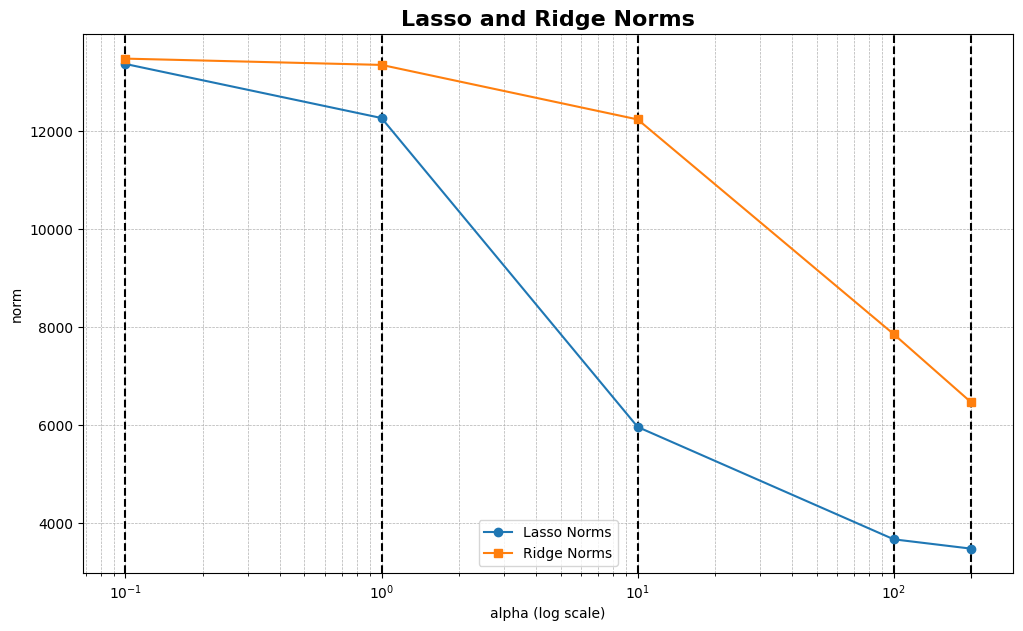

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lasso_norms = []
ridge_norms = []
alphas = [0.1, 1, 10, 100, 200] 
for alpha in alphas:
    lasso_norms.append(np.linalg.norm(Lasso(alpha=alpha).fit(X_train_scaled, y_train).coef_))
    ridge_norms.append(np.linalg.norm(Ridge(alpha=alpha).fit(X_train_scaled, y_train).coef_))
    ax.axvline(alpha, linestyle='--', color='black')

ax.plot(alphas, lasso_norms, label='Lasso Norms', marker='o')
ax.plot(alphas, ridge_norms, label='Ridge Norms', marker='s')

ax.set_xscale('log')
ax.set_xticks(alphas)  
ax.set_title('Lasso and Ridge Norms', fontweight='bold', fontsize=16)
ax.set_xlabel('alpha (log scale)')
ax.set_ylabel('norm')
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.show()

LASSO сильнее снижает норму коэффициентов. L1 регуляризация может обнулить отдельный признак, если он не важен или мультиколинеарен. L2 регуляризация уменьшает веса для признаков, не не обнуляет их.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [35]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(cv=5).fit(X_train_scaled, y_train)
best_alpha = lassocv.alpha_

print(f"Оптимальное alpha: {best_alpha}")
print(f'MSE on test set: {mean_squared_error(y_test, lassocv.predict(X_test_scaled)):.2f}')


Оптимальное alpha: 3.6811541284381177
MSE on test set: 1314322.76


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [36]:
lasso2 = Lasso(alpha=best_alpha)
lasso2.fit(X_train_scaled, y_train)

lasso_coefs2 = pd.DataFrame(lasso2.coef_, index=X_train.columns, columns=['Lasso Coefs2'])
pd.merge(pd.merge(coefs, lasso_coefs, left_index=True, right_index=True), pd.merge(ridge_coefs, lasso_coefs2, left_index=True, right_index=True), left_index=True, right_index=True) 

,coefs,Lasso Coefs,Ridge Coefs,Lasso Coefs2
carat,5351.710922,4779.474849,5299.337241,5129.196834
depth,-92.652241,-155.493543,-95.464808,-125.098518
table,-61.827127,-107.538653,-64.336125,-83.196206
x,-1222.174398,-719.760126,-1178.044945,-988.774326
y,72.354096,-0.000000,69.843236,-0.000000
z,-21.090872,-8.131070,-23.171820,-12.573203
color_E,-195.559323,2.793867,-184.536782,-2.154990
color_F,-265.494670,-0.000000,-253.817873,-72.209901
color_G,-480.794158,-126.276307,-464.100691,-271.328450
color_H,-967.973016,-597.351288,-951.139766,-753.333311


Наиболее информативными оказались признаки carat, признаки цветов, и чистоты (можно заметить иерархию между значениями, прямо как в описание датасета). Неинформативным оказался признак `y` - слишком сильно коррелировал с другими признаками, как было упомянуто ранее.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [37]:
print(f'Lasso 2 MSE: {mean_squared_error(y_test, lasso2.predict(X_test_scaled)):.2f}')
print(f'Linear MSE: {mean_squared_error(y_test, regrs.predict(X_test_scaled)):.2f}')

Lasso 2 MSE: 1314322.76
Linear MSE: 1272888.94


Показатель MSE лучше у обчной регрессии. Модель LASSO регрессии получилась почти такой же, что и обычная модель линейной регрессии. Разница по MSE < 5%. Линейная модель оказалась достаточно устойчивой, вероятно из-за того, что данные были отнормированы (StandardScaler), при применении One-Hot-Encoding также были убраны лишние столбцы, что снижало мультиколлинеарность. 